In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import numpy as np
from os import listdir
from os.path import isfile, join, isdir
import logging
import colorcet as cc
from matplotlib.ticker import ScalarFormatter
import matplotlib
import matplotlib.pyplot as plt
from typing import List
from matplotlib import rcParams

logging.getLogger('matplotlib.pyplot').setLevel(logging.WARNING)

logger = logging.getLogger('Plots_Log')
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

rcParams['figure.figsize'] = 11.7,8.27

# Palette and markers

In [2]:
pivots = ["BPP", "CONVEX", "FFT", "SSS", "MAXSEPARATED", "MAXVARIANCE", "PCA", "IS", "HFI", "WDR", "SELECTION", "KMEDOIDS", "RANDOM"]
palette = sns.color_palette(cc.glasbey, n_colors=12)
palette_pivots = dict(zip(pivots, palette))
markers = ["o", "v", "^", "<", "s", "p", "P", "X", "d", "H", ">", "*"]
markers_pivots = dict(zip(pivots, markers))

# Read dataframe

In [3]:
def read_data(basePath: str, index: str, dataset: str, pivot: str, idx: int = 0) -> pd.DataFrame:
    
    if basePath is None:
        logger.error("Empty path")
    
    plot_folder = join(basePath, index.upper() + '_' + dataset.upper() + '_' + pivot.upper() + '_' + str(idx))
    
    if not isdir(plot_folder):
        logger.error("Directory does not exist")
        
    experimentsFiles = [join(plot_folder, f) for f in listdir(plot_folder) if 'experiment' in f]
    
    data = pd.DataFrame()
    
    for exptFile in experimentsFiles:
        aux = pd.read_csv(exptFile)
        data = pd.concat([data, aux], ignore_index=True)
    
    logger.info(f' Number of lines read: {data.shape[0]}')
    
    return data

# Individual plots

In [31]:
def plot_distance(basePath: str, index: str, dataset: str, pivots: List[str], agg: str = 'mean', idx: int = 0) -> matplotlib.axes._axes.Axes:
    
    if agg != 'mean' and agg != 'median':
        logger.critical("Unsupported aggregation method")
        
    data_agg = pd.DataFrame()
    
    for pivot in pivots:
        data = read_data(basePath, index, dataset, pivot, idx) 
        data = data.drop(['expt_id', 'r', 'time', 'sys_time', 'user_time', 'prunning', 'iowrite', 'ioread'], axis=1)
        data['k'] = pd.to_numeric(data['k'])
        data['distCount'] = pd.to_numeric(data['distCount'])
        k_range = list(range(data['k'].unique().min(), data['k'].unique().max()+1, 5))
        rows_list = []

        for k in k_range:
            aux_data = data[data['k'] == k]
            rows_list.append({'k': k, 'distCount': aux_data.agg({'distCount': agg}).iloc[0], 'pivot': pivot.upper()})
        
        data_agg = pd.concat([pd.DataFrame(rows_list), data_agg], axis=0)

    plot = sns.lineplot(data=data_agg, x='k', y='distCount', hue='pivot', style='pivot', 
                        palette=palette_pivots, markers=markers_pivots)
    plot.set(xlabel='K')
    plot.set(ylabel='Number of distance computations')
    xticksList = [5, 50, 100]
    plot.set(xticks=xticksList)
    plot.set_xticklabels(xticksList)
    plot.set(xlim=(5,100))
    plot.set(title=index.upper() + '_' + dataset.upper())
    ax = plot.axes
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    sns.set_context("paper", font_scale=1.9) 
    
    return plt

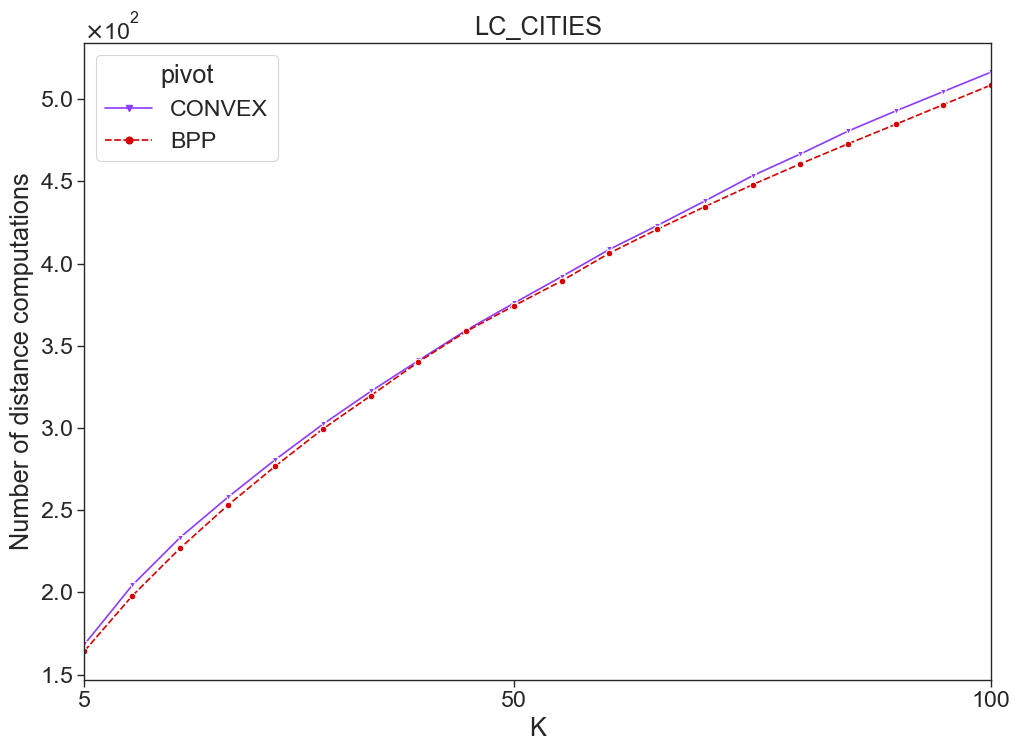

In [34]:
plot = plot_distance(basePath='output_files', index='lc', dataset='cities', pivots=['bpp', 'convex'], agg='mean')

# Multiples plots

In [43]:
def grid_plot_distance(basePath: str, indexes: List[str], datasets: List[str], pivots: List[str], agg: str = 'mean', idx: int = 0) -> None:
    
    nrows = len(datasets)
    ncols = len(indexes)
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12, 6))
    
    if len(datasets) == 1:
        for i in range(len(indexes)):
            plt.subplot(nrows, ncols, i + 1)
            plt_aux = plot_distance(basePath=basePath, index=indexes[i], dataset=datasets[0], pivots=pivots, agg=agg, idx=idx)
    else:
        for i in range(len(indexes)):
            for j in range(len(datasets)):
                plt.subplot(nrows, ncols, i * ncols + j + 1)
                plt_aux = plot_distance(basePath=basePath, index=indexes[i], dataset=datasets[j], pivots=pivots, agg=agg, idx=idx)
                
    sns.set_context("paper", font_scale=2) 
                
    fig.subplots_adjust(wspace=0.2, hspace=0.1)

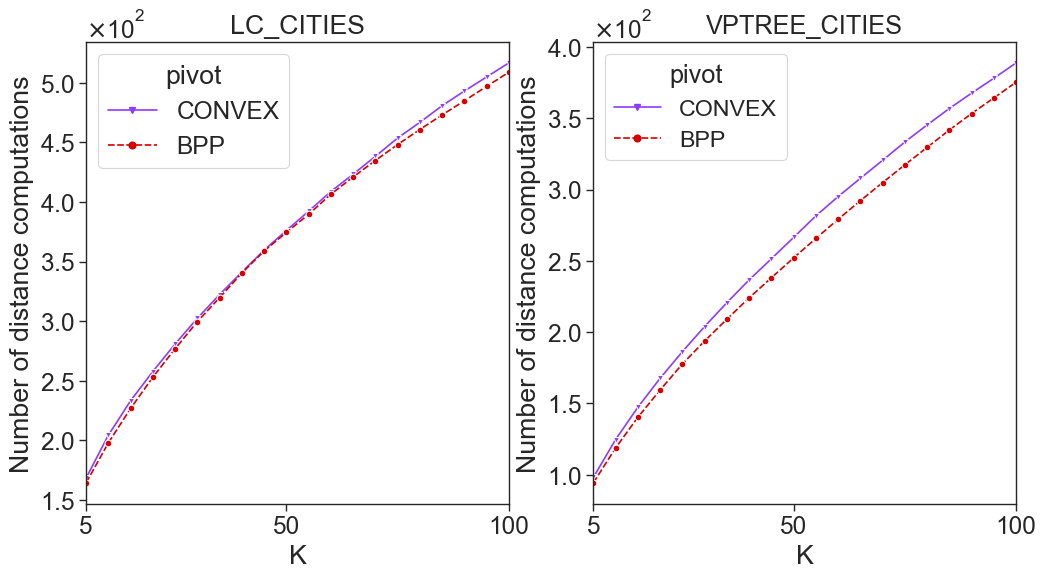

In [45]:
grid_plot_distance('output_files', ['LC', 'VPTREE'], ['cities'], ['bpp', 'convex'], 'mean')